In [5]:
include("../pic3d.jl")
using .PIC3D
using PyPlot
using LinearAlgebra
using PyCall
anim =  pyimport("matplotlib.animation");

In [6]:
function generate_particles!(NP, d)
    num = d / (2*NP / (PIC3D.XL*PIC3D.YL*PIC3D.ZL))
    println(num)
    electrons = PIC3D.Species(q=PIC3D.q_e*num, m=PIC3D.m_e*num)
    ions = PIC3D.Species(q=-PIC3D.q_e*num, m=PIC3D.m_e*num*2000)
    @inbounds for i = 1:NP
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
        
        x = [rand()*PIC3D.XL, rand()*PIC3D.YL, rand()*PIC3D.ZL]
        v = [-5e5, 0, 0]
        push!(electrons.x, [x...])
        push!(electrons.v, [v...])
        push!(ions.x, [x...])
        push!(ions.v, [v...])
    end

    return electrons, ions
end

generate_particles! (generic function with 1 method)

In [7]:
function compute_EK_particles(electrons, ions)
    ek = 0
    @inbounds for i in eachindex(electrons.v)
        ek += electrons.m*dot(electrons.v[i], electrons.v[i])
    end
    @inbounds for i in eachindex(ions.v)
        ek += ions.m*dot(ions.v[i], ions.v[i])
    end
    ek = 0.5*ek
    return ek
end

function compute_EP_field()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.Ex[i,j,k]^2 + PIC3D.Ey[i,j,k]^2 + PIC3D.Ez[i,j,k]^2
    end
    ep = 0.5 * PIC3D.ε_0 * ep * PIC3D.Δx*PIC3D.Δy*PIC3D.Δz
    return ep
end


function compute_EP_potential()
    ep = 0
    @inbounds for k = 1:(PIC3D.NZ-1), j = 1:(PIC3D.NY-1), i = 1:(PIC3D.NX-1)
        ep += PIC3D.ρ[i,j,k] * PIC3D.ϕ[i,j,k]
    end
    ep = 0.5* PIC3D.ε_0 *ep
    return ep
end

compute_EP_potential (generic function with 1 method)

In [39]:
size(historyxx)

(120,)

MovieWriter ffmpeg unavailable; using Pillow instead.


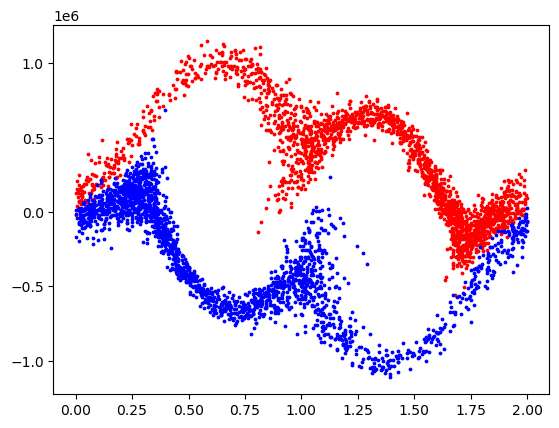

In [44]:
fig = plt.figure()

function make_frame(i)
    plt.clf()
    firstx = historyxx[i+1][1:2:(size(historyxx[1])[1])]
    firstv = historyvel[i+1][1:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in firstx], [p[1] for p in firstv], s =3, color="red")
    secondx = historyxx[i+1][2:2:(size(historyxx[1])[1] )]
    secondv = historyvel[i+1][2:2:(size(historyxx[1])[1])]
    plt.scatter([p[1] for p in secondx], [p[1] for p in secondv], s =3, color="blue")
end

myanim = anim.FuncAnimation(fig, make_frame, frames=120, interval=50, blit=false)
myanim[:save]("nowy1.gif", bitrate=-1)


In [ ]:
NP = 2048 #2048
d = 4.5e9
electrons, ions = generate_particles!(NP, d)

Δt = 1e-9
timesteps = 3000

historyxx = []
historyvel = []
EK = []
EE = []
EP = []

for i = 1:timesteps
    println(i)
    PIC3D.timestep!(electrons, ions, 1)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

2.197265625e6
1
ϕ:
[-0.10081413415395545 -0.14760073294035558 -0.1982107643784598; -0.16748322241964717 -0.19773460736070095 -0.12360413913774676; -0.1919217527958207 -0.15993293265965136 -0.11300777454228252;;; -0.07405659097104654 -0.1004996033868305 -0.1754533817231155; -0.18092467501939904 -0.12251211811376096 -0.09856255137163854; -0.12804765477785882 -0.10118011551619911 -0.07646060306952857;;; -0.06539331721837041 -0.06152638305010885 -0.06548712289969791; -0.11197396578497669 -0.07330829365521827 -0.05673562744280622; -0.08395414650381104 -0.06297451723993922 -0.04752524085487979]
R1:
[-136.48033980871486 -80.86137102276982 -61.02180620115418; -70.33136283221162 -48.54080623260322 -40.0198280571917; -52.74283180376624 -28.645372972645404 -30.060042440286892;;; -81.65281228892276 -31.42329682723212 -31.82938649933594; -37.240162843729934 -6.85485505096824 -12.357010806386853; -27.769031792408683 -6.019386223921259 -9.083655710366259;;; -34.80182386213666 -21.897593631857795 -19.

Excessive output truncated after 524290 bytes.

-1.4542948027426611e26; 8.295998041171519e25 -1.4419175232085114e26 -2.6956898175436503e26]
R4:
[2.6806770122947628e25 6.4640507755149184e25 7.524617372360361e25; 1.007910651381943e26 8.295996372330049e25 6.744242997621252e25; 8.429204726283445e25 4.3047290688434185e24 -4.028267900852468e25;;; 6.464051076253875e25 3.131213081213416e25 1.747774253844535e25; 8.295998041171519e25 -2.4990516797854523e26 -2.7487428015885782e26; 4.3047529150790895e24 -2.5713989206257526e26 -2.2964046950192967e26;;; 7.524612323058403e25 1.7477724343518988e25 -3.2186048144134536e24; 6.7442411660870804e25 -2.7487405981472874e26 -2.807596256131223e26; -4.028269226050718e25 -2.2964014881285128e26 -1.630066510116003e26]
EPS4:
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 -3.3710984008163936e24 -3.7844176236298195e24; 0.0 -2.6615506774076065e24 -2.2912132073708601e24;;; 0.0 0.0 0.0; 0.0 -3.7844148700525614e24 -4.053795428999369e24; 0.0 -2.291209004288766e24 -1.450876227933251e24]
EPS2:
[0.0 0.0 0.0; 0.

In [ ]:
for i = 1:timesteps
    println(i)
    PIC3D.timestep!(electrons, ions)
    if i % 25 == 0
        plt.figure()
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 0],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 0], color="red", label="c = 1", s=2)
        plt.scatter([electrons.x[i][1] for i in eachindex(electrons.x) if i % 2 == 1],
                    [electrons.v[i][1] for i in eachindex(electrons.v) if i % 2 == 1], color="blue", label="c = 1", s=2)
        plt.xlabel("x [m]")
        plt.ylabel("vel x [m/s]")
        plt.show()
        push!(historyxx, [[ex...] for ex in electrons.x])
        push!(historyvel, [[ev...] for ev in electrons.v])
    end
    push!(EK, compute_EK_particles(electrons, ions))
    push!(EE, compute_EP_field())
    push!(EP, compute_EP_potential())
end

1
GS failed to converge, L2 = 4.600414370911968
2
GS failed to converge, L2 = 4.599976039782248
3
GS failed to converge, L2 = 4.599535204548113
4
GS failed to converge, L2 = 4.5990865404841115
5
GS failed to converge, L2 = 4.598662139599573
6
GS failed to converge, L2 = 4.600311140033389
7
GS failed to converge, L2 = 4.599860863986483
8
GS failed to converge, L2 = 4.578026456701914
9
GS failed to converge, L2 = 4.589979457204339
10
GS failed to converge, L2 = 4.589568862795642
11
GS failed to converge, L2 = 4.589156050649198
12
GS failed to converge, L2 = 4.5887409994091755
13
GS failed to converge, L2 = 4.588323687004677
14
GS failed to converge, L2 = 4.587904439646749
15
GS failed to converge, L2 = 4.5876347402717155
16
GS failed to converge, L2 = 4.608689543825877
17
GS failed to converge, L2 = 4.60848420280518
18
GS failed to converge, L2 = 4.6083581256158075
19
GS failed to converge, L2 = 4.6295565683521085
20
GS failed to converge, L2 = 4.5912803215793705
21
GS failed to converge

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



GS failed to converge, L2 = 4.612643501936915
27
GS failed to converge, L2 = 4.612676127032869
28
GS failed to converge, L2 = 4.612709313629353
29
GS failed to converge, L2 = 4.591430884571302
30
GS failed to converge, L2 = 4.591456944011033
31
GS failed to converge, L2 = 4.591553976056264
32
GS failed to converge, L2 = 4.591630277050861
33
GS failed to converge, L2 = 4.591667664810722
34
GS failed to converge, L2 = 4.591701885252879
35
GS failed to converge, L2 = 4.591732919397011
36
GS failed to converge, L2 = 4.591776120457812
37
GS failed to converge, L2 = 4.610057700633906
38
GS failed to converge, L2 = 4.588637701227007
39
GS failed to converge, L2 = 4.567098254035878
40
GS failed to converge, L2 = 4.5668261851411796
41
GS failed to converge, L2 = 4.587783864963683
42
GS failed to converge, L2 = 4.566006739837651
43
GS failed to converge, L2 = 4.565554564148381
44
GS failed to converge, L2 = 4.586455974796524
45
GS failed to converge, L2 = 4.585931196648151
46
GS failed to conve

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


GS failed to converge, L2 = 4.385336154158296
527
GS failed to converge, L2 = 4.422302604129883
528
GS failed to converge, L2 = 4.419858731063064
529
GS failed to converge, L2 = 4.420784631954811
530
GS failed to converge, L2 = 4.421718471426295
531
GS failed to converge, L2 = 4.40130531132494
532
GS failed to converge, L2 = 4.402188521152313
533
GS failed to converge, L2 = 4.45579494231112
534
GS failed to converge, L2 = 4.4564501151722995
535
GS failed to converge, L2 = 4.478412495278182
536
GS failed to converge, L2 = 4.457650363394697
537
GS failed to converge, L2 = 4.442988865321955
538
GS failed to converge, L2 = 4.4433029782963365
539
GS failed to converge, L2 = 4.464924066494456
540
GS failed to converge, L2 = 4.4652133387681125
541
GS failed to converge, L2 = 4.465473675429634
542
GS failed to converge, L2 = 4.444406182028364
543
GS failed to converge, L2 = 4.423314257034927
544
GS failed to converge, L2 = 4.42356431470211
545
GS failed to converge, L2 = 4.445160874909174
546


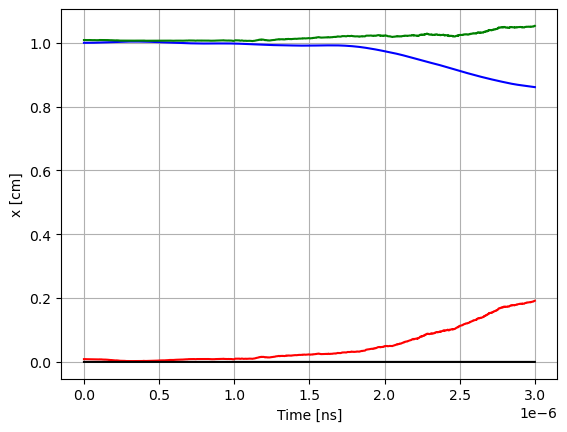

PyObject Text(24.000000000000007, 0.5, 'x [cm]')

In [43]:
fig = plt.figure()
times = [i*Δt for i=1:timesteps]
plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

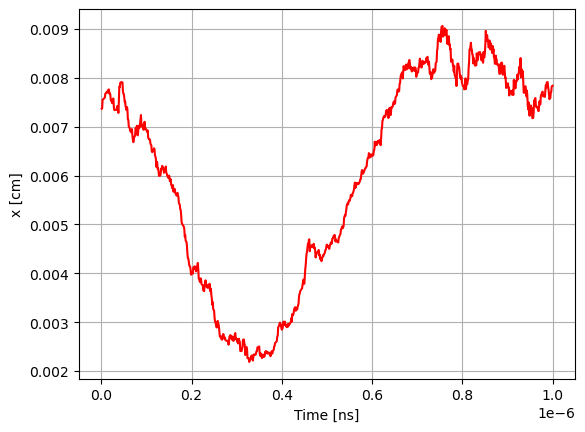

PyObject Text(24.0, 0.5, 'x [cm]')

In [22]:
fig = plt.figure()
times = [i*Δt for i=1:timesteps]
plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
#plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
#plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")

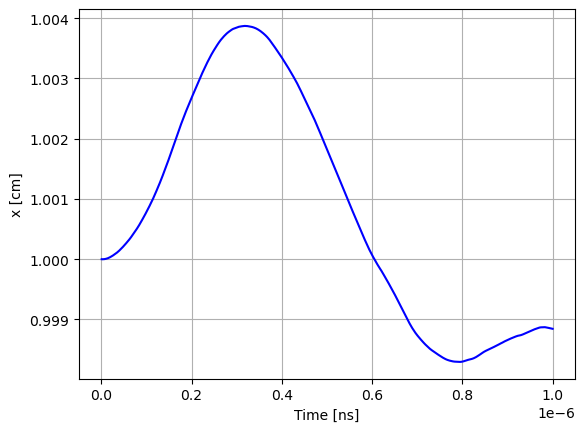

PyObject Text(24.0, 0.5, 'x [cm]')

In [23]:
fig = plt.figure()
times = [i*Δt for i=1:timesteps]
#plt.plot(times, EE ./ EK[1], linestyle="solid", color="red")
plt.plot(times, EK ./ EK[1], linestyle="solid", color="blue")
#plt.plot(times, EE ./ EK[1] + EK ./ EK[1], linestyle="solid", color="green")
#plt.plot(times, EP ./ EK[1], linestyle="solid", color="black")
plt.grid()
plt.xlabel("Time [ns]")
plt.ylabel("x [cm]")